In [1]:
%matplotlib widget
import random
import matplotlib.pyplot as plt
from camera import Camera
from dorna2 import Dorna, Kinematic
import numpy as np
import cv2
from paddleocr import PaddleOCR
from IPython.display import display, clear_output
import config
import time
from dorna_vision import util
import ncnn
from ncnn.utils.objects import Detect_Object

In [2]:
class Yolo(object):
    def __init__(self, param_path, bin_path, class_names, target_size=416, num_threads=2, use_gpu=False):
        self.target_size = target_size
        self.num_threads = num_threads
        self.use_gpu = use_gpu

        self.mean_vals = []
        self.norm_vals = [1 / 255.0, 1 / 255.0, 1 / 255.0]

        self.net = ncnn.Net()
        self.net.opt.use_vulkan_compute = self.use_gpu
        self.net.opt.num_threads = self.num_threads

        self.net.load_param(param_path)
        self.net.load_model(bin_path)

        self.class_names = class_names

    def __del__(self):
        self.net = None

    def __call__(self, img, conf=0.5, max_det=None):
        img_h = img.shape[0]
        img_w = img.shape[1]

        mat_in = ncnn.Mat.from_pixels_resize(
            img,
            ncnn.Mat.PixelType.PIXEL_BGR2RGB,
            img.shape[1],
            img.shape[0],
            self.target_size,
            self.target_size,
        )
        mat_in.substract_mean_normalize(self.mean_vals, self.norm_vals)

        ex = self.net.create_extractor()
        ex.input("data", mat_in)

        ret, mat_out = ex.extract("output")

        objects = []

        # method 1, use ncnn.Mat.row to get the result, no memory copy
        for i in range(mat_out.h):
            values = mat_out.row(i)

            obj = Detect_Object()
            obj.prob = values[1]
            if obj.prob < conf:
                continue
            
            obj.label = values[0]-1
            obj.rect.x = values[2] * img_w
            obj.rect.y = values[3] * img_h
            obj.rect.w = values[4] * img_w - obj.rect.x
            obj.rect.h = values[5] * img_h - obj.rect.y

            objects.append(obj)

        # top elements
        if max_det:
            # Sort the list by 'prob' in descending order
            sorted_objects = sorted(objects, key=lambda x: x.prob, reverse=True)
            
            # Select the top `max_det` elements
            objects = sorted_objects[:max_det]

        return objects


# helper function for drawing the result
def draw_detection_objects(image, class_names, objects):
    for obj in objects:
    
        cv2.rectangle(
            image,
            (int(obj.rect.x), int(obj.rect.y)),
            (int(obj.rect.x + obj.rect.w), int(obj.rect.y + obj.rect.h)),
            (255, 0, 0),
        )
    
        text = "%s %.1f%%" % (class_names[int(obj.label)], obj.prob * 100)
    
        label_size, baseLine = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
    
        x = obj.rect.x
        y = obj.rect.y - label_size[1] - baseLine
        if y < 0:
            y = 0
        if x + label_size[0] > image.shape[1]:
            x = image.shape[1] - label_size[0]
    
        cv2.rectangle(
            image,
            (int(x), int(y)),
            (int(x + label_size[0]), int(y + label_size[1] + baseLine)),
            (255, 255, 255),
            -1,
        )
    
        cv2.putText(
            image,
            text,
            (int(x), int(y + label_size[1])),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.5,
            (0, 0, 0),
        )
    
    return image


"""
helper functions
"""
# classification of bad or good cardamom
def img_classification(results, area_thr):
    # init
    cls = -1 # no pick
    good = 0
    
    for i in range(len(results)):        
        box = [[results[i].rect.x, results[i].rect.y], [results[i].rect.x+results[i].rect.w, results[i].rect.y],  [results[i].rect.x+results[i].rect.w, results[i].rect.y+results[i].rect.h], [results[i].rect.x, results[i].rect.y+results[i].rect.h]]
        
        # check area
        area = results[i].rect.w * results[i].rect.h
        if area >= min(area_thr) and area <= max(area_thr):
            continue
        
        # class
        cls_tmp = results[i].label

        # adjust the goods
        good += cls_tmp

        # one bad found
        if cls_tmp == 0:
            cls = cls_tmp
            return cls
    
    # one good at least, otherwise no pick
    if good > 0:
        cls = 1
    
    return cls
    
# pick a value with highest probability which is also a float number
def weight_classification(results, weight_thr):
    cls = 0
    conf = 0
    weight = 0

    # loopp over all the result
    print("results: ", results)
    if results[0] is not None:
        for result in results[0]:
            try:
                weight_tmp = float(result[1][0])
                if result[1][1] >= conf:
                    weight = weight_tmp
                    conf = result[1][1]
            except:
                pass
    
        #print("weight: ", weight)
        if weight >= weight_thr:
            cls = 1        
    print("weight: ", weight)
    return cls
    
# pick an item with highest confidence that is within the min and max area, retuen the center of the mass of the detected object
def object_location(crop, robot, kinematic, T_cam_2_j4, camera, depth_frame, depth_int, results,  area_thr, xyz_thr):
    # init
    sol = False
    xyz_target_2_base = [0, 0, 0]
    pxl = [0, 0]
    cls = 0

    # randomization
    index = list(range(len(results))) 
    random.shuffle(index) # reshuffle        

    # loop for solution
    for i in index:
        box = [[results[i].rect.x, results[i].rect.y], [results[i].rect.x+results[i].rect.w, results[i].rect.y],  [results[i].rect.x+results[i].rect.w, results[i].rect.y+results[i].rect.h], [results[i].rect.x, results[i].rect.y+results[i].rect.h]]

        # class
        cls = results[i].label


        # check area
        area = results[i].rect.w * results[i].rect.h
        if area <= min(area_thr) or area >= max(area_thr):
            continue

        # Calculate centroid (center) of the bb
        pxl = crop.pxl_to_orig([int(results[i].rect.x + results[i].rect.w/2), int(results[i].rect.y + results[i].rect.h/2)])
        
        # xyz_target to robot
        xyz_target_2_cam, _ = camera.xyz(pxl, depth_frame, depth_int)
        T_target_2_cam = np.eye(4)
        T_target_2_cam[:3, 3] = np.ravel(xyz_target_2_cam)
        
        # current joint and pose
        joint = robot.get_all_joint()
        T_j4_2_base = kinematic.Ti_r_world(i=5, joint=joint[0:6])
        
        # target_2_base
        T_target_2_base = np.matmul(T_j4_2_base, np.matmul(T_cam_2_j4, T_target_2_cam) )
        xyz_target_2_base =T_target_2_base[:3, 3].flatten().tolist()[0] 

        # check xyz
        if any([xyz_target_2_base[i] <= min(xyz_thr[i]) or xyz_target_2_base[i] >= max(xyz_thr[i]) for i in range(len(xyz_target_2_base))]):
            continue
        
        # break the loop
        sol = True
        return cls, xyz_target_2_base, pxl, sol
    
    return cls, xyz_target_2_base, pxl, sol

In [ ]:
"""
Initialize model and export it to ncnn formt
"""
# Load a 
net = Yolo("cardamom/model_x.param", "cardamom/model_x.param", ["cardamom_bad", "cardamom_good"])

# ocr model
ocr = PaddleOCR(use_angle_cls=False, lang='en')  # Disable text orientation classification

In [45]:
"""
Initialize camera, robot and the inverse kinematic engine
"""
# camera ground
camera_ground = Camera()
print("ground connected: ", camera_ground.connect(serial_number=config.camera_ground_sn))

# camera on robot
camera_robot = Camera()
print("Camera robot connected: ", camera_robot.connect(serial_number=config.camera_robot_sn))

# Robot
robot = Dorna()
print("Robot connected: ", robot.connect(config.robot_ip))

# kinematics
kinematic = Kinematic(config.robot_model)

ground connected:  True
Camera robot connected:  True
Robot connected:  True


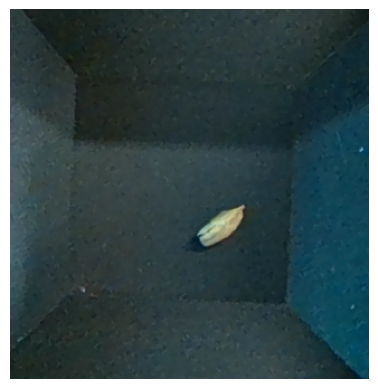

In [46]:
"""
main loop
"""
# save data
save_img = 0 # number of images to take

# init
robot.play_list(cmd_list=config.start)

# number of time it failed detection
failed_counter = 0

for i in range(1):
    """
    failed counter
    """
    if failed_counter > config.mix_thr:
        failed_counter = 0 # restart
        robot.play_list(cmd_list=config.bin_mix)
        continue
    
    """
    search for candidate
    """
    robot.play_list(cmd_list=config.bin_image) # bin region
    depth_frame, _, _, _, _, color_img, depth_int, _, _= camera_robot.get_all() # camera data
    crop = util.Crop(color_img, config.bin_roi, rot=True) # crop
    color_img_mask = crop.cropped_img # crop
    results = net(color_img_mask, conf=config.detection_conf, max_det=config.max_det) # detection
    cls, xyz_target_2_base, pxl, sol = object_location(crop, robot, kinematic, config.T_cam_2_j4, camera_robot, depth_frame, depth_int, results, config.area_thr, config.xyz_thr) # picking candidate
    # save image
    if save_img > 0: #
        cv2.imwrite("img/"+str(time.time())+".jpg", color_img)
        save_img -= 1
    """
    Display
    """
    # Clear the previous output
    #clear_output(wait=True)
    plt.imshow(cv2.cvtColor(draw_detection_objects(color_img_mask, net.class_names, results), cv2.COLOR_BGR2RGB)) # Display the image
    plt.axis('off')  # Turn off axis
    display(plt.gcf())  # Display the updated plot
    plt.close() # release the memory

    continue
    
    #sol = False
    if not sol: # no candidate
        failed_counter += 1
        continue
    
    """
    picking
    """
    config.pick[0] = {**config.pick[0], **{"x": xyz_target_2_base[0], "y": xyz_target_2_base[1], "z": xyz_target_2_base[2]+config.tcp_length+5}} # adjust pick xyz
    robot.play_list(cmd_list=config.pick) # pick

    """
    bad after pick
    """
    if cls == 0: # bad
        robot.play_list(cmd_list=config.bad_bin_after_pick) # drop
        continue
    
    """
    quality check
    """
    robot.play_list(cmd_list=config.quality)

    # takes 4 images
    color_img_mask_list = []
    for j5 in [-90, -30, 30, 90]:
        robot.jmove(rel=0, j5=j5)
        robot.sleep(0.2)
        _, _, _, _, _, color_img, _, _, _= camera_ground.get_all() # camera data
        crop = util.Crop(color_img, config.quality_roi, rot=False)
        color_img_mask_list.append(crop.cropped_img) # mask

    
    # form larger image
    color_img_mask = np.vstack([np.hstack([color_img_mask_list[0], color_img_mask_list[1]]), np.hstack([color_img_mask_list[2], color_img_mask_list[3]])])
    plt.imshow(cv2.cvtColor(color_img_mask, cv2.COLOR_BGR2RGB)) # Display the image
    plt.axis('off')  # Turn off axis
    display(plt.gcf())  # Display the updated plot
    plt.close() # release the memory
  
    results = net(color_img_mask, conf=config.detection_conf) # detection
    cls = img_classification(results, config.area_thr) # quality decision

    """
    Display
    """
    # Clear the previous output
    #clear_output(wait=True)
    plt.imshow(cv2.cvtColor(draw_detection_objects(color_img_mask, net.class_names, results), cv2.COLOR_BGR2RGB)) # Display the image
    plt.axis('off')  # Turn off axis
    display(plt.gcf())  # Display the updated plot
    plt.close() # release the memory
    
    if cls == -1: # no pick
        continue
    elif cls == 0: # bad
        robot.play_list(cmd_list=config.bad_bin_after_quality) # drop
        continue

    """
    weight
    """
    robot.play_list(cmd_list=config.weight)
    
    _, _, _, _, _, color_img, _, _, _= camera_robot.get_all() # camera data
    #crop = util.Crop(color_img, config.ocr_roi, rot=False)
    #color_img_mask = crop.cropped_img # mask
    color_img_mask = util.roi_mask(color_img, config.ocr_roi)
    
    results = ocr.ocr(color_img_mask, cls=False)  # ocr
    cls = weight_classification(results, config.weight_thr) # classification

    """
    Display
    """
    # Clear the previous output
    #clear_output(wait=True)
    plt.imshow(cv2.cvtColor(color_img_mask, cv2.COLOR_BGR2RGB)) # Display the image
    plt.axis('off')  # Turn off axis
    display(plt.gcf())  # Display the updated plot
    plt.close() # release the memory

    if cls == 0: # bad
        robot.play_list(cmd_list=config.drop_bad)
    else: # good
        robot.play_list(cmd_list=config.drop_good)

In [44]:
"""
Always close the camera and robot, once your application is over
"""
# terminate the session
camera_ground.close()
camera_robot.close()
robot.close()

True